In [2]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from glob import glob


# ESR+EducImm+Refugee Network

In [191]:
model = gum.BayesNet()

statusLabel = ['Born in Canada', 'Immigrants, landed 5 or less years earlier',
               'Immigrants, landed more than 10 years earlier',
               'Immigrants, landed more than 5 to 10 years earlier']

model.add(gum.LabelizedVariable('Status','Status',statusLabel)) 

educationLabel = ['0 to 8  years', 'Some high school',
       'High school graduate', 'Some postsecondary',
       'Postsecondary certificate or diploma', 'University degree']

model.add(gum.LabelizedVariable('Education','Education',educationLabel)) 
model.add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:8]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

sexLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))

initYear = 2016
yearLabel = [str(i+initYear) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

nodeList = ["Economic",
            "Sponsor",
            "Refugee",
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Sex')

model.addArc('Province','Employment Rate')
model.addArc('Sex','Employment Rate')
model.addArc('Education','Employment Rate')
model.addArc('Year','Employment Rate')
model.addArc('Status','Employment Rate')

model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model.addArc('Year','Sponsor')
model.addArc('Year','Refugee')
model.addArc('Year','Economic')

model.addArc('Year','Province')
model.addArc('Origin','Province')

model


(pyAgrum.BayesNet<double>@0000024DD4BA0F20) BN{nodes: 11, arcs: 16, domainSize: 10^12.8741, dim: 355229, mem: 2Mo 755Ko 704o}

In [179]:
population_imm_df = pd.read_csv("population_immigration.csv")
er_imm_df = pd.read_csv("employment_immigration.csv")

population_imm_df = population_imm_df.loc[:, ["REF_DATE","GEO","Immigrant status","VALUE"]]
population_imm_df.columns = ["Date", "Province", "Status","Population"]

er_imm_df = er_imm_df.loc[:, ["VALUE"]]
er_imm_df.columns = ["Employment Rate"]

pop_imm_er_df = population_imm_df.join(er_imm_df)

population_df = pd.read_csv("population_education.csv")
er_df = pd.read_csv("employment_education.csv")
population_df = population_df.loc[:, ["REF_DATE","GEO","Sex","Educational attainment","VALUE"]]
population_df.columns = ["Date", "Province", "Sex", "Education","Population"]

er_df = er_df.loc[:, ["VALUE"]]
er_df.columns = ["Employment Rate"]

pop_er_df = population_df.join(er_df)
temp_edu_df = pop_er_df.groupby(["Date","Province","Sex","Education"]).mean()
temp_imm_df = pop_imm_er_df.groupby(["Date","Province","Status"]).mean()

statusList = population_imm_df["Status"].unique()
dateList = [str(2015+index//12)+"-"+str(1+(index%12)).zfill(2) for index in range(12*8)]
provinceList = pop_er_df["Province"].unique()
educationList = population_df["Education"].unique()

data = []
for d in dateList:
    for p in provinceList:
        for s in sexLabel:
            for e in educationList:
                edu_data = temp_edu_df.loc[d].loc[p].loc[s+"s"].loc[e]
                
                ava_status_data = temp_imm_df.loc[d].loc[p].Population
                ava_status_data = ava_status_data/ava_status_data[-1]
                
                employed_status_data = temp_imm_df.loc[d].loc[p].Population * temp_imm_df.loc[d].loc[p].loc[:,"Employment Rate"]/100
                employed_status_data = employed_status_data/employed_status_data[-1]
                
                for status in statusList:
                    available = ava_status_data.loc[status] * edu_data[0]
                    employed = employed_status_data.loc[status] * edu_data[1]/100 * edu_data[0]
                    
                    data.append([d,p,s,e,status,available,employed,100*employed/available])


combined_df = pd.DataFrame(data, columns=["Date", "Province","Sex","Education", "Status","Population","Employed","Employment Rate"])                        
                

In [192]:
canada_df = combined_df[combined_df["Province"]=="Canada"]

model.cpt("Status")[:] = [canada_df.groupby("Status").mean().Population[i] for i in range(len(statusLabel))]

avg_df =  canada_df.groupby(["Education"]).mean()
avg_df =  avg_df.groupby("Education").sum()

for education in educationLabel:
    dictionary = {"Education":education}
    model.cpt("Education")[dictionary] = avg_df.loc[education, "Population"]

avg_df = combined_df.groupby(["Province","Sex","Education","Status","Date"]).mean()

for province in provinceLabel:
    for sex in sexLabel:
        for education in educationLabel:
            for status in statusLabel:
                dictionary = {"Sex":sex, "Province":province, "Status":status, "Education":education}
                all_province_df = avg_df.loc[province].loc[sex].loc[education].loc[status]

                for index, year in enumerate(yearLabel):
                    dictionary["Year"]=year
                    
                    arr = (all_province_df.iloc[index*12: (index+1)*12,-1])
                    arr = arr[~np.isnan(arr)]
                    hist = np.histogram(arr, 101,(0,100))[0]
                    data =  hist/sum(hist)

                    model.cpt("Employment Rate")[dictionary] = data

In [193]:
#populate gender/origin/age/year
df2 = df.groupby("Year").sum()
year_values = [value for value in df2.loc[:,"Total"]]
model.cpt("Year")[:] = year_values[-len(yearLabel):]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Sex")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in sexLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

In [194]:
#dataset has different names for countries

replaceDictionary = {"China, People's Republic of":"China",
                     "Iran":"Iran (Islamic Rep. of)",
                     "Turkey":"Türkiye",
                     "Congo, Democratic Republic of the":'Dem. Rep. of the Congo',
                    "Somalia, Democratic Republic of":'Somalia',
                    "South Sudan, Republic of":'South Sudan',
                    "Sudan, Democratic Republic of":'Sudan',
                    "Syria":'Syrian Arab Rep.',
                    "Venezuela":'Venezuela (Bolivarian Republic of)'
                    }

to_canada_df = pd.read_csv("originCountry.csv").iloc[:,1:]

to_canada_df.Country.replace(replaceDictionary, inplace=True)

to_canada_df = to_canada_df[to_canada_df["Country"].isin(countryLabel)]
df = {}
pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]

    if index == 0:
        total_per_month = np.array(df[p].Total)
    else:
        total_per_month += np.array(df[p].Total)

total_pr = np.array(to_canada_df.iloc[:,1:].sum())


for index, cLabel in enumerate(to_canada_df.Country):
    temp_df = to_canada_df[to_canada_df["Country"]==cLabel]
    temp_df = temp_df.iloc[0,1:]
    
    for tIndex, tLabel in enumerate(temp_df):
        if tIndex % 12 == 0:
            province_data = np.zeros((len(provinceLabel)))
            
        for pIndex, pLabel in enumerate(provinceLabel):
            percent_to_province = df[pLabel].Total[tIndex]/total_per_month[tIndex]
            
            province_data[pIndex]+=(temp_df[tIndex]*percent_to_province)
            
        if (initYear+tIndex//12) >= 2023:
            continue
        model.cpt("Province")[{"Year":str(initYear+tIndex//12), "Origin":cLabel}]=province_data    
        
pr = {p:{y:{d:0 for d in rangeNode.keys()} for y in yearLabel} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    province_df = data.iloc[:,1:]
    
    for yIndex, y in enumerate(yearLabel):
        yearly_province_df = province_df.iloc[yIndex*12:(yIndex+1)*12]
        
        for d in nodeList:
            arr = np.array(yearly_province_df[d])

            hist = np.histogram(arr, bins[d])[0]
            pr[p][y][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    for yIndex, y in enumerate(yearLabel):
        dictionary={"Province":p,"Year":y}
        model.cpt("Economic")[dictionary] = pr[p][y]["Economic"]
        model.cpt("Sponsor")[dictionary] = pr[p][y]["Sponsor"]
        model.cpt("Refugee")[dictionary] = pr[p][y]["Refugee"]        

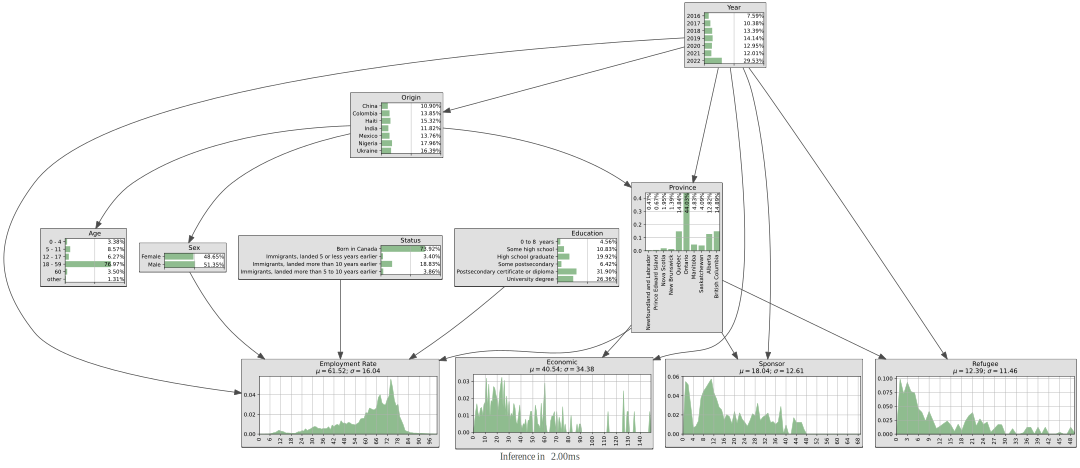

In [196]:
model.cpt("Education").normalizeAsCPT()
model.cpt("Status").normalizeAsCPT()
model.cpt("Employment Rate").normalizeAsCPT()
model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Sex").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Refugee").normalizeAsCPT()
model.cpt("Sponsor").normalizeAsCPT()
model.cpt("Economic").normalizeAsCPT()

esr_edu_imm_ref_model = model

gnb.showInference(esr_edu_imm_ref_model, evs={},size="15")


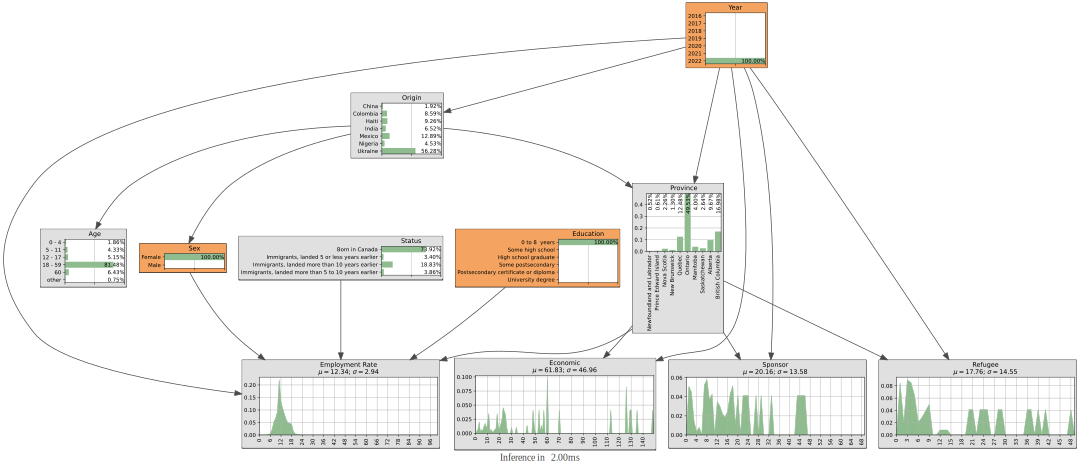

In [205]:
gnb.showInference(esr_edu_imm_ref_model, evs={"Year":"2022","Education":0,"Sex":"Female"},size="15")

# ESR+Educ+Refugee Network

In [2]:
model = gum.BayesNet()

educationLabel = ['0 to 8  years', 'Some high school',
       'High school graduate', 'Some postsecondary',
       'Postsecondary certificate or diploma', 'University degree']

model.add(gum.LabelizedVariable('Education','Education',educationLabel)) 
model.add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:8]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

sexLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))

initYear = 2016
yearLabel = [str(i+initYear) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Sex')

nodeList = ["Economic",
            "Sponsor",
            "Refugee",
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Province','Employment Rate')
model.addArc('Sex','Employment Rate')
model.addArc('Education','Employment Rate')

model.addArc('Year','Employment Rate')

model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model.addArc('Year','Sponsor')
model.addArc('Year','Refugee')
model.addArc('Year','Economic')

model.addArc('Year','Province')
model.addArc('Origin','Province')

model


(pyAgrum.BayesNet<double>@000001D3F53743D0) BN{nodes: 10, arcs: 15, domainSize: 10^12.272, dim: 103226, mem: 815Ko 224o}

In [4]:
population_df = pd.read_csv("population_education.csv")
er_df = pd.read_csv("employment_education.csv")
population_df = population_df.loc[:, ["REF_DATE","GEO","Sex","Educational attainment","VALUE"]]
population_df.columns = ["Date", "Province", "Sex", "Education","Population"]

er_df = er_df.loc[:, ["VALUE"]]
er_df.columns = ["Employment Rate"]

pop_er_df = population_df.join(er_df)
    
canada_df = pop_er_df[pop_er_df["Province"]=="Canada"]

avg_df =  canada_df.groupby("Education").mean()
for education in educationLabel:
    dictionary = {"Education":education}
    model.cpt("Education")[dictionary] = avg_df.loc[education, "Employment Rate"]
    
for province in provinceLabel:
    temp_df = pop_er_df[pop_er_df["Province"]==province] 
    for gender in sexLabel:
        for education in educationLabel:
            dictionary = {"Sex":gender, "Province":province, "Education":education}
            all_province_df = temp_df[(temp_df["Sex"]==gender+"s") & (temp_df["Education"]==education)]
            
            for index, year in enumerate(yearLabel):
                yearly_province_df = all_province_df.iloc[index*12: (index+1)*12]
                dictionary["Year"]=year
                
                arr = np.array(yearly_province_df.loc[:,"Employment Rate"])
                arr = arr[~np.isnan(arr)]
                hist = np.histogram(arr, 101,(0,100))[0]
                data =  hist/sum(hist)

                model.cpt("Employment Rate")[dictionary] = data

In [6]:
#populate gender/origin/age/year
df2 = df.groupby("Year").sum()
year_values = [value for value in df2.loc[:,"Total"]]
model.cpt("Year")[:] = year_values[-len(yearLabel):]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Sex")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in sexLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

In [7]:
#dataset has different names for countries

replaceDictionary = {"China, People's Republic of":"China",
                     "Iran":"Iran (Islamic Rep. of)",
                     "Turkey":"Türkiye",
                     "Congo, Democratic Republic of the":'Dem. Rep. of the Congo',
                    "Somalia, Democratic Republic of":'Somalia',
                    "South Sudan, Republic of":'South Sudan',
                    "Sudan, Democratic Republic of":'Sudan',
                    "Syria":'Syrian Arab Rep.',
                    "Venezuela":'Venezuela (Bolivarian Republic of)'
                    }

to_canada_df = pd.read_csv("originCountry.csv").iloc[:,1:]

to_canada_df.Country.replace(replaceDictionary, inplace=True)

to_canada_df = to_canada_df[to_canada_df["Country"].isin(countryLabel)]
df = {}
pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]

    if index == 0:
        total_per_month = np.array(df[p].Total)
    else:
        total_per_month += np.array(df[p].Total)

total_pr = np.array(to_canada_df.iloc[:,1:].sum())


for index, cLabel in enumerate(to_canada_df.Country):
    temp_df = to_canada_df[to_canada_df["Country"]==cLabel]
    temp_df = temp_df.iloc[0,1:]
    
    for tIndex, tLabel in enumerate(temp_df):
        if tIndex % 12 == 0:
            province_data = np.zeros((len(provinceLabel)))
            
        for pIndex, pLabel in enumerate(provinceLabel):
            percent_to_province = df[pLabel].Total[tIndex]/total_per_month[tIndex]
            
            province_data[pIndex]+=(temp_df[tIndex]*percent_to_province)
            
        if (initYear+tIndex//12) >= 2023:
            continue
        model.cpt("Province")[{"Year":str(initYear+tIndex//12), "Origin":cLabel}]=province_data    
        
pr = {p:{y:{d:0 for d in rangeNode.keys()} for y in yearLabel} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    province_df = data.iloc[:,1:]
    
    for yIndex, y in enumerate(yearLabel):
        yearly_province_df = province_df.iloc[yIndex*12:(yIndex+1)*12]
        
        for d in nodeList:
            arr = np.array(yearly_province_df[d])

            hist = np.histogram(arr, bins[d])[0]
            pr[p][y][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    for yIndex, y in enumerate(yearLabel):
        dictionary={"Province":p,"Year":y}
        model.cpt("Economic")[dictionary] = pr[p][y]["Economic"]
        model.cpt("Sponsor")[dictionary] = pr[p][y]["Sponsor"]
        model.cpt("Refugee")[dictionary] = pr[p][y]["Refugee"]        

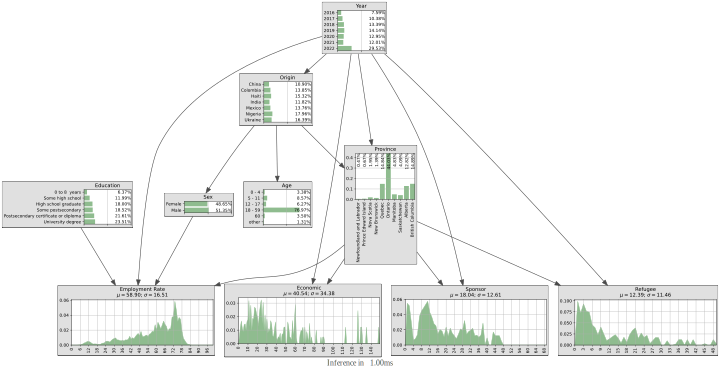

In [8]:
model.cpt("Education").normalizeAsCPT()
model.cpt("Employment Rate").normalizeAsCPT()
model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Sex").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Refugee").normalizeAsCPT()
model.cpt("Sponsor").normalizeAsCPT()
model.cpt("Economic").normalizeAsCPT()

esr_edu_ref_model = model

gnb.showInference(esr_edu_ref_model, evs={},size="10")


In [199]:
gnb.showInference(esr_edu_ref_model, evs={"Year":"2016"},size="10")

NameError: name 'esr_edu_ref_model' is not defined

# ESR+Refugee Network

In [10]:
model = gum.BayesNet()
            
df = pd.read_csv("demographics.csv")
df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:8]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

sexLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Sex','Sex',sexLabel))
yearLabel = [str(i+2001) for i in range(22)]

initYear = 2016
yearLabel = [str(i+initYear) for i in range(7)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Sex')

nodeList = ["Economic",
            "Sponsor",
            "Refugee",
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model.addArc('Year','Sponsor')
model.addArc('Year','Refugee')
model.addArc('Year','Economic')

model.addArc('Year','Province')
model.addArc('Origin','Province')

model

(pyAgrum.BayesNet<double>@000001D3F80B9700) BN{nodes: 8, arcs: 11, domainSize: 10^9.48954, dim: 19221, mem: 152Ko 368o}

In [12]:
#populate gender/origin/age/year

df2 = df.groupby("Year").sum()
year_values = [value for value in df2.loc[:,"Total"]]
model.cpt("Year")[:] = year_values[-len(yearLabel):]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Sex")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in sexLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

In [13]:
#dataset has different names for countries

replaceDictionary = {"China, People's Republic of":"China",
                     "Iran":"Iran (Islamic Rep. of)",
                     "Turkey":"Türkiye",
                     "Congo, Democratic Republic of the":'Dem. Rep. of the Congo',
                    "Somalia, Democratic Republic of":'Somalia',
                    "South Sudan, Republic of":'South Sudan',
                    "Sudan, Democratic Republic of":'Sudan',
                    "Syria":'Syrian Arab Rep.',
                    "Venezuela":'Venezuela (Bolivarian Republic of)'
                    }

to_canada_df = pd.read_csv("originCountry.csv").iloc[:,1:]

to_canada_df.Country.replace(replaceDictionary, inplace=True)

to_canada_df = to_canada_df[to_canada_df["Country"].isin(countryLabel)]
df = {}
pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]

    if index == 0:
        total_per_month = np.array(df[p].Total)
    else:
        total_per_month += np.array(df[p].Total)

total_pr = np.array(to_canada_df.iloc[:,1:].sum())


for index, cLabel in enumerate(to_canada_df.Country):
    temp_df = to_canada_df[to_canada_df["Country"]==cLabel]
    temp_df = temp_df.iloc[0,1:]
    
    for tIndex, tLabel in enumerate(temp_df):
        if tIndex % 12 == 0:
            province_data = np.zeros((len(provinceLabel)))
            
        for pIndex, pLabel in enumerate(provinceLabel):
            percent_to_province = df[pLabel].Total[tIndex]/total_per_month[tIndex]
            
            province_data[pIndex]+=(temp_df[tIndex]*percent_to_province)
            
        if (initYear+tIndex//12) >= 2023:
            continue
        model.cpt("Province")[{"Year":str(initYear+tIndex//12), "Origin":cLabel}]=province_data    
        
pr = {p:{y:{d:0 for d in rangeNode.keys()} for y in yearLabel} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    province_df = data.iloc[:,1:]
    
    for yIndex, y in enumerate(yearLabel):
        yearly_province_df = province_df.iloc[yIndex*12:(yIndex+1)*12]
        
        for d in nodeList:
            arr = np.array(yearly_province_df[d])

            hist = np.histogram(arr, bins[d])[0]
            pr[p][y][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    for yIndex, y in enumerate(yearLabel):
        dictionary={"Province":p,"Year":y}
        model.cpt("Economic")[dictionary] = pr[p][y]["Economic"]
        model.cpt("Sponsor")[dictionary] = pr[p][y]["Sponsor"]
        model.cpt("Refugee")[dictionary] = pr[p][y]["Refugee"]        

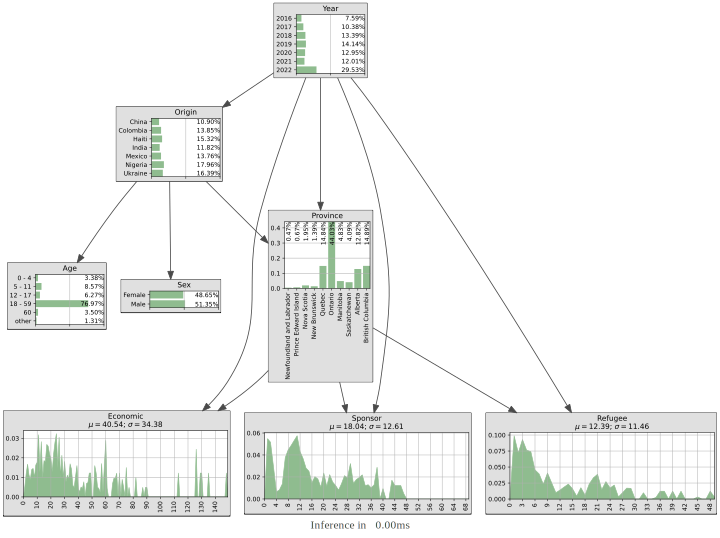

In [14]:
#model.cpt("Total").fillWithFunction("(Sponsor+Economic+Refugee)")
model.cpt("Year").normalizeAsCPT()
model.cpt("Origin").normalizeAsCPT()
model.cpt("Age").normalizeAsCPT()
model.cpt("Sex").normalizeAsCPT()
model.cpt("Province").normalizeAsCPT()
model.cpt("Refugee").normalizeAsCPT()
model.cpt("Sponsor").normalizeAsCPT()
model.cpt("Economic").normalizeAsCPT()

esr_ref_model = model

gnb.showInference(esr_ref_model, evs={},size="10")


In [198]:
def nodevalue(n, default=-1):
    value = 0
    
    if n in {"Sex","Education","Province","Employment Rate"}:
        value = 0.2
        if default == 0:
            return value
        
    if n in {"Year","Province","Economic","Sponsor","Refugee"}:
        value = 0.7
        if default == 1:
            return value
        
    if n in {"Year","Origin","Age","Sex"}:
        value = 0.8
        if default == 2:
            return value
        
    if n in {"Year","Status","Province"}:
        value = 0.4
        if default == 3:
            return value
        
    if n in {"Sex","Year","Province"}:
        value = 1
        
    return value

import pyAgrum.lib.image as gumimage
gumimage.exportInference(esr_ref_model,"bn_refugee+pr.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n) for n in esr_ref_model.names()})

gumimage.exportInference(esr_edu_ref_model,"bn_refugee+pr+edu.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n) for n in esr_edu_ref_model.names()})

gumimage.exportInference(esr_edu_imm_ref_model,"bn_refugee+pr+edu.pdf",
                         targets={},evs={},
                         nodeColor={n:nodevalue(n) for n in esr_edu_imm_ref_model.names()})

